> # Neural Network Basic - Week3 과제


## Import Library

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [3]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [48]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(self, x):
        return 1 / (1 + np.exp(-x)) * (1 - 1 / (1 + np.exp(-x)))

In [22]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximum(0, x)
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        if x > 0: return 1
        else: return 0

In [23]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [24]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [25]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [30]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr
        self.epoch = epoch  
        self.batch_size = batch_size
        self.loss_function = cross_entropy 
        self.layers = []
        self.activations = [softmax]
        self.nodes = []
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) 
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size))
        self.nodes.append(np.zeros(Layer.output_size))
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() 
        self.activations.append(Activation) 
        self.activations.append(tmp) 
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() 
        output = X.copy() 
        for i in range(len(self.layers)): 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            output = np.dot(self.nodes[i], Layer.weight) 
            output = output+ Layer.bias 
            output = Activation.forward(output) 
            self.nodes[i+1] = output 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): 
            a = self.nodes[i+1] 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            if i+1 == len(self.layers): 
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] 
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T) 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1)
        return np.sum(pre_p==y)/y.shape[0] 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch):
            for j in range(N//self.batch_size): 
                batch_mask = np.random.choice(N, self.batch_size)
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) 
                self._backward(X_batch, output, y_batch)
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [31]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [32]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [33]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1028
0 test loss     : 23081.46873020276
10 test accuracy : 0.1135
10 test loss     : 22849.743744416865
20 test accuracy : 0.1743
20 test loss     : 22655.78985693716
30 test accuracy : 0.2164
30 test loss     : 22300.49193546658
40 test accuracy : 0.2435
40 test loss     : 21502.713131452623
50 test accuracy : 0.269
50 test loss     : 20135.390001964126
60 test accuracy : 0.302
60 test loss     : 18830.305088114066
70 test accuracy : 0.4179
70 test loss     : 17475.49322146682
80 test accuracy : 0.4706
80 test loss     : 15656.732142450013
90 test accuracy : 0.5416
90 test loss     : 14025.348764943345
100 test accuracy : 0.6069
100 test loss     : 12471.316873906422
110 test accuracy : 0.6573
110 test loss     : 11014.157927193273
120 test accuracy : 0.6975
120 test loss     : 9834.864318631366
130 test accuracy : 0.7345
130 test loss     : 8889.073078578089
140 test accuracy : 0.7648
140 test loss     : 8090.536518690909
150 test accuracy : 0.7924
150 test loss 

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

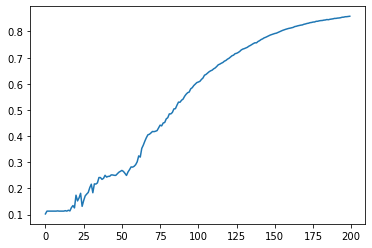

In [68]:
import matplotlib.pyplot as plt
plt.plot(history['val_acc'])